In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
image_dim = 28*28
latent_dim = 2
learning_rate = 0.0025
batch_size = 64

In [3]:
class Encoder(nn.Module):
  def __init__(self, image_dim, hidden_dims, latent_dim):
    super(Encoder, self).__init__()
    dims = [image_dim] + hidden_dims
    self.encoder = nn.Sequential()
    for in_dim, out_dim in zip(dims, dims[1:]):
      self.encoder.append(nn.Linear(in_dim, out_dim))
      self.encoder.append(nn.ReLU())
    self.encoder.append(nn.Linear(hidden_dims[-1], latent_dim))

  def forward(self, x):
    x = x.view(-1, image_dim)
    return self.encoder(x)

In [4]:
class Decoder(nn.Module):
  def __init__(self, image_dim, hidden_dims, latent_dim):
    super(Decoder, self).__init__()
    dims = [latent_dim] + hidden_dims[::-1]
    self.decoder = nn.Sequential()
    for in_dim, out_dim in zip(dims, dims[1:]):
        self.decoder.append(nn.Linear(in_dim, out_dim))
        self.decoder.append(nn.ReLU())
    self.decoder.append(nn.Linear(dims[-1], image_dim))
    self.decoder.append(nn.Sigmoid())

  def forward(self, z):
    return self.decoder(z)

In [5]:
class AutoEncoder(nn.Module):
  def __init__(self, image_dim, latent_dim, hidden_dims=[512, 256]):
    super(AutoEncoder, self).__init__()
    self.encoder = Encoder(image_dim, hidden_dims, latent_dim)
    self.decoder = Decoder(image_dim, hidden_dims, latent_dim)
  
  def forward(self, x):
    z = self.encoder(x)
    return self.decoder(z)

In [6]:
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [7]:
autoencoder = AutoEncoder(image_dim, latent_dim)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
autoencoder

AutoEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

In [8]:
autoencoder.train()
for e in range(3):
  with tqdm(train_dataloader) as pbar:
    for i, (x, _) in enumerate(pbar):
      x = x.view(-1, 784)
      x_hat = autoencoder(x)
      loss = loss_fn(x, x_hat)

      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()
      
      if i % 50 == 0:
        pbar.set_description(f"Epoch {e+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.0419: 100%|██████████| 938/938 [00:05<00:00, 159.30it/s]
Epoch 2 | Loss: 0.0439: 100%|██████████| 938/938 [00:05<00:00, 157.77it/s]
Epoch 3 | Loss: 0.0369: 100%|██████████| 938/938 [00:05<00:00, 165.24it/s]


Original size: 3136 bytes | Compressed size: 8 bytes | Compression ratio: 392.00x


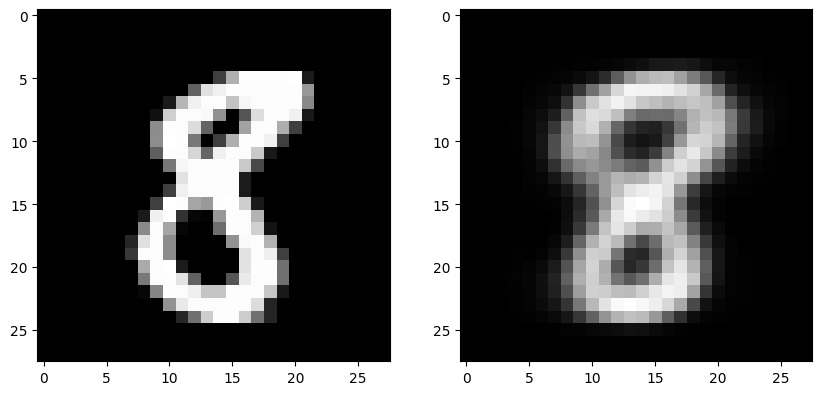

In [9]:
x_comp = autoencoder.encoder(x[0].view(-1, 784))
x_hat = autoencoder.decoder(x_comp).detach()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x[0].reshape(28, 28), cmap="gray")
ax[1].imshow(x_hat[0].reshape(28, 28), cmap="gray")

orig_size = x[0].numel() * 4
comp_size = x_comp.numel() * 4
ratio = orig_size / comp_size
print(f"Original size: {orig_size} bytes | Compressed size: {comp_size} bytes | Compression ratio: {ratio:.2f}x")

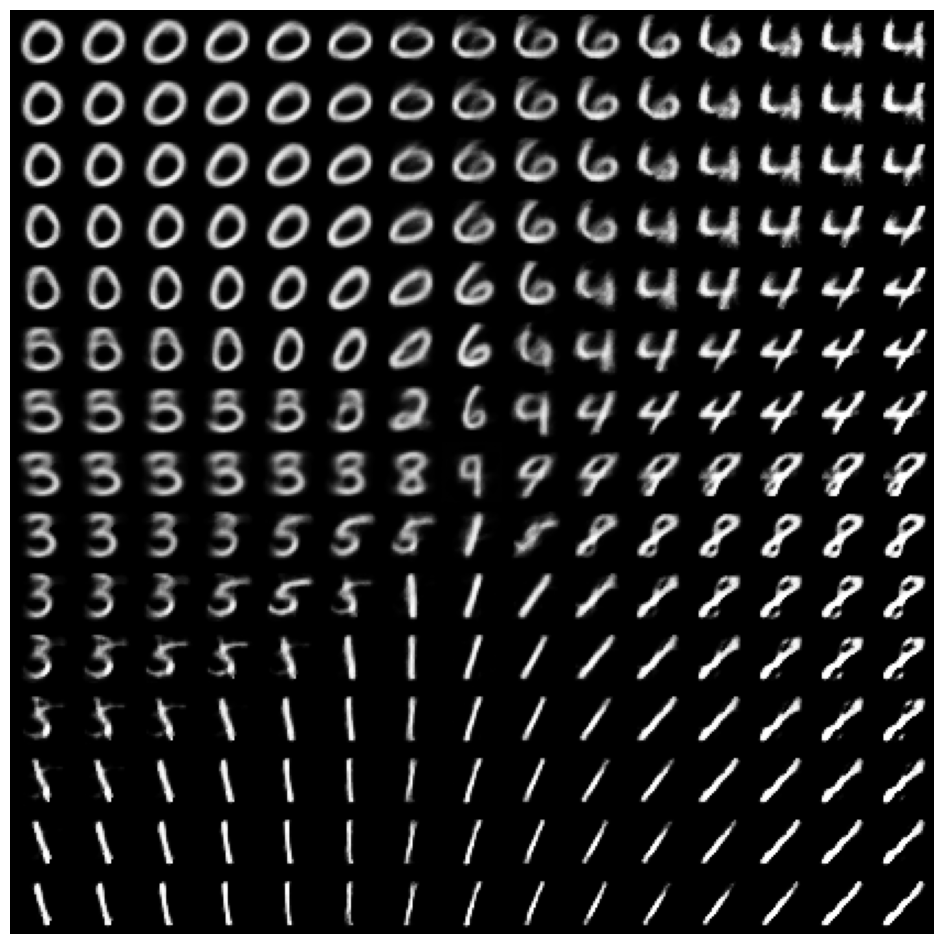

In [10]:
autoencoder.eval()
imgs = None
with torch.no_grad():
  for x in torch.linspace(-10, 10, 15):
    row = None
    for y in torch.linspace(-10, 10, 15):
      z = torch.tensor([x, y], dtype=torch.float32)
      img = autoencoder.decoder(z).view(28, 28)
      row = img if row is None else torch.cat((row, img), 1)
    imgs = row if imgs is None else torch.vstack((row, imgs))
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.imshow(imgs.detach().numpy(), cmap="gray")

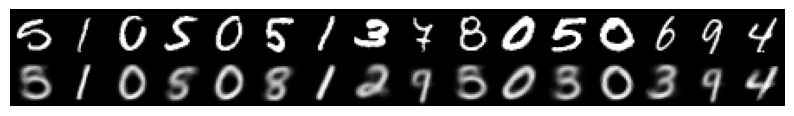

In [11]:
x, _ = next(iter(test_dataloader))
x = x.view(-1, 28, 28)
with torch.no_grad():
  x_hat = autoencoder(x).reshape(-1, 28, 28)

imgs = None
for i in range(batch_size // 4):
  cat = torch.vstack((x[i], x_hat[i]))
  imgs = cat if imgs is None else torch.hstack((imgs, cat))
plt.figure(figsize=(10, batch_size // 4))
plt.axis("off")
plt.imshow(imgs.detach(), cmap="gray")

In [12]:
latent_dim = 8
autoencoder = AutoEncoder(image_dim, latent_dim, hidden_dims=[512, 256, 128])
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [13]:
autoencoder.train()
for e in range(3):
  with tqdm(train_dataloader) as pbar:
    for i, (x, _) in enumerate(pbar):
      x = x.view(-1, 784)
      noisy_x = x + (torch.randn_like(x) * 0.5) 
      noisy_x = noisy_x.clamp(0, 1)
      x_hat = autoencoder(noisy_x)
      loss = loss_fn(x, x_hat)

      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()
      
      if i % 50 == 0:
        pbar.set_description(f"Epoch {e+1} | Loss: {loss.item():.4f}")

Epoch 1 | Loss: 0.0377: 100%|██████████| 938/938 [00:06<00:00, 143.76it/s]
Epoch 2 | Loss: 0.0276: 100%|██████████| 938/938 [00:06<00:00, 145.28it/s]
Epoch 3 | Loss: 0.0287: 100%|██████████| 938/938 [00:06<00:00, 146.13it/s]


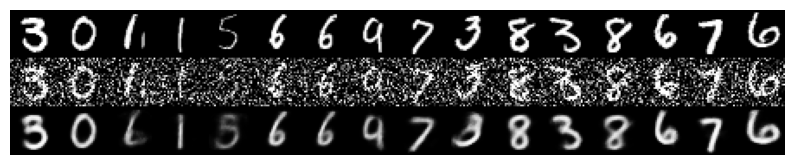

In [14]:
autoencoder.eval()
x, _ = next(iter(test_dataloader))
x = x.view(-1, 28, 28) 
noisy_x = x + (torch.randn_like(x) * 0.5)
noisy_x = noisy_x.clamp(0, 1)
with torch.no_grad():
  x_hat = autoencoder(noisy_x).reshape(-1, 28, 28)

imgs = None
for i in range(batch_size // 4):
  cat = torch.vstack((x[i], noisy_x[i], x_hat[i]))
  imgs = cat if imgs is None else torch.hstack((imgs, cat))
plt.figure(figsize=(10, batch_size // 4))
plt.axis("off")
plt.imshow(imgs.detach(), cmap="gray", norm=None)